In [1]:
# set of function for choosing the connection probability to give to bmtk

In [2]:
import h5py
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import mplcursors
#import mpld3


def SaveDataToDF(f):
    myData = []
    myDataNames = []
    def saveDat(item):
        if 'Data' in str(f[item].id):
            data2use = f[item][()]
            if data2use.ndim == 2:#some groups have multiple columns and this messes up the translation to a df at the end of this function
                [a,b] = data2use.shape
                for col in np.arange(0,b):
                    myData.append(data2use[:,col])
                    dataName = (f[item].name).split('/')[-1] + str(col)
                    myDataNames.append(dataName)
            else:
                myData.append(f[item][()])
                dataName = (f[item].name).split('/')[-1]
                myDataNames.append(dataName)
        
    f.visit(saveDat)
    allData = pd.DataFrame(myData).T
    allData.columns = myDataNames
    f.close()
    return allData

In [5]:
f = h5py.File(os.path.join('network','biophysical_nodes.h5'), 'r')
nodesDF = SaveDataToDF(f)
cellLocations = pd.read_csv('cell_locations.csv')#this was for the old build, i'm just reading it instead of writing the list coz lazy
idNames = np.unique(nodesDF['node_type_id'])
cellNames = np.unique(cellLocations['Cell type'])
array = cellLocations['Cell type']
idxs = np.unique(cellLocations['Cell type'],return_index=True)[1]
cellNames = [array[index] for index in sorted(idxs)]#use the names in the order in which the id's appear

nodesDF = nodesDF.replace({'node_type_id':idNames},{'node_type_id':cellNames})

In [ ]:
def get_conn_probs_V2(nodesDF,src,trgt,convergence,max_dist):
    srcs = nodesDF[nodesDF['node_type_id'].str.contains(src)]
    trgts = nodesDF[nodesDF['node_type_id'].str.contains(trgt)]

    xs = srcs['positions0']
    ys = srcs['positions1']
    zs = srcs['positions2']

    all_src_positions = np.vstack((xs,ys,zs)).T


    xs = trgts['positions0']
    ys = trgts['positions1']
    zs = trgts['positions2']

    all_trgt_positions = np.vstack((xs,ys,zs)).T


    squared_distances = np.sum((all_src_positions[:, np.newaxis, :] - all_trgt_positions) ** 2, axis=2)
    euclidean_distances = np.sqrt(squared_distances)
    
    
    
    collect = []
    for i in range(euclidean_distances.shape[1]):
        possible_srcs = np.where(euclidean_distances[:,i] <= max_dist)[0]
        connection_probability = convergence / len(possible_srcs)
        collect.append(connection_probability)
    return np.mean(collect)

In [9]:
from scipy.stats import norm

max_distance = 400

def make_lookup(mean,std_dev,pmax ):
    x = np.arange((-1)*max_distance,max_distance)
    pdf_values = norm.pdf(x, loc=mean, scale=std_dev)
    scaled_pdf_values = pdf_values * (pmax / np.max(pdf_values))
    scaled_pdf_values = scaled_pdf_values[max_distance:]
    pdf_lookup = pd.DataFrame(scaled_pdf_values)
    return pdf_lookup

i2e_lookup = make_lookup(0,96.6,0.15)
e2i_lookup = make_lookup(0,99.84,0.12)
i2i_lookup = make_lookup(0,126.77,0.12)

In [ ]:
#I want a conn prob of pdf_values = norm.pdf(x, loc=mean, scale=std_dev) such that for x of size N, np.random.uniform() <= conn prob occurs a convergence number of times

In [25]:
from scipy import stats
from scipy.optimize import minimize

# Define the negative log-likelihood function
def neg_log_likelihood(params, data, dist):
    # Set the parameters of the distribution object
    dist_params = dist.fit(data, floc=0)  # Use 0 as the location parameter for simplicity

    # Set the fitted parameters
    dist_params[:-2] = params

    # Calculate the negative log-likelihood
    neg_log_likelihood = -np.sum(dist.logpdf(data, *dist_params))

    return neg_log_likelihood



In [26]:
# Generate some example data from a specific distribution
data = stats.norm.rvs(loc=0, scale=1, size=100)

# Define the distribution you want to fit
dist = stats.norm




In [27]:
# Set initial parameter values
initial_params = [0, 1]  # Example initial parameters

# Perform MLE using scipy.optimize.minimize
result = minimize(neg_log_likelihood, initial_params, args=(data, dist))

# Get the estimated parameters
estimated_params = result.x
print("Estimated parameters:", estimated_params)

TypeError: 'tuple' object does not support item assignment

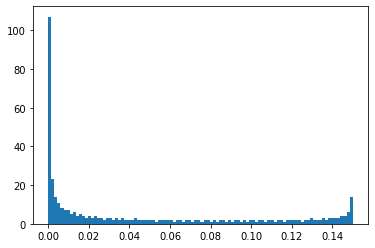

In [13]:
plt.hist(i2e_lookup,bins=100)
plt.show()

In [4]:
def get_all_possible_conns(nodesDF,src,trgt,max_dist,return_distances = False):
    
    srcs = nodesDF[nodesDF['node_type_id'].str.contains(src)]
    trgts = nodesDF[nodesDF['node_type_id'].str.contains(trgt)]

    xs = srcs['positions0']
    ys = srcs['positions1']
    zs = srcs['positions2']

    all_src_positions = np.vstack((xs,ys,zs)).T

    xs = trgts['positions0']
    ys = trgts['positions1']
    zs = trgts['positions2']

    all_trgt_positions = np.vstack((xs,ys,zs)).T
    
    squared_distances = np.sum((all_src_positions[:, np.newaxis, :] - all_trgt_positions) ** 2, axis=2)
    euclidean_distances = np.sqrt(squared_distances)
    collect = []
    collect_dist = []
    for i in range(euclidean_distances.shape[0]):
        possible_srcs_num = len(np.where(euclidean_distances[i,:] <= max_dist)[0]) 
        collect.append(possible_srcs_num)
    if return_distances == True:
        return collect, euclidean_distances#note these are all distances, not just the ones below 400
    else:
        return collect

In [6]:
src,trgt = 'AAC','Pyr'
max_dist = 400

srcs = nodesDF[nodesDF['node_type_id'].str.contains(src)]
trgts = nodesDF[nodesDF['node_type_id'].str.contains(trgt)]

xs = srcs['positions0']
ys = srcs['positions1']
zs = srcs['positions2']

all_src_positions = np.vstack((xs,ys,zs)).T


xs = trgts['positions0']
ys = trgts['positions1']
zs = trgts['positions2']

all_trgt_positions = np.vstack((xs,ys,zs)).T


squared_distances = np.sum((all_src_positions[:, np.newaxis, :] - all_trgt_positions) ** 2, axis=2)
euclidean_distances = np.sqrt(squared_distances)



In [ ]:
def test_func(srcs, trgts, dist,pdf_lookup):
    seed_value = 123
    np.random.seed(seed_value)
    
    if dist <= 300:
        
        test_prob = np.random.uniform()
        #print(pdf_lookup.iloc[int(dist)].iloc[0])
        dist_conn_prob = pdf_lookup.iloc[int(dist)].iloc[0]

        if test_prob <= dist_conn_prob:
            return 1, dist
        else:
            return 0

In [ ]:
collect = []
for i in range(euclidean_distances.shape[1]):
    possible_srcs = np.where(euclidean_distances[:,i] <= max_dist)[0]
    connection_probability = convergence / len(possible_srcs)
    collect.append(connection_probability)

In [ ]:
i=0
possible_srcs = np.where(euclidean_distances[:,i] <= max_dist)[0]
connection_probability = convergence / len(possible_srcs)
collect.append(connection_probability)